The video provided by Netflix ends while buffalo are still entering the frame; therefore, it is possible that we have missed part of the herd in our count. In order to estimate the number of animals we may have missed, we fit a regression line to the data and use this to forecast the likely end of the herd and estimate how many animals we may have missed.

We plot the data using several different time intervals (2, 5, and 10 second bins) and compare the predictions.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import pickle
import sys
import os

%matplotlib inline

In [2]:
# Import custom functions
working_dir = os.getcwd()
functions_directory = os.path.join(working_dir, 'functions')
sys.path.append(functions_directory)
from count_forecasting import *

In [3]:
# Import tracks
tracks = np.load('/home/blair/mababe-megaherd-data/data/retained_tracks.npy', allow_pickle = True)

We need to count how many animals cross the count line in each n-second video bin. 
The count line is at a heigh of 100 pixels. The video is 368 seconds long in total.
We can use the get_bin_counts function to generate counts for different bin lengths.

In [4]:
# Count how many tracks cross the line in each bin
auto_counts_2sec = get_bin_counts(tracks, bin_length = 2)
auto_counts_5sec = get_bin_counts(tracks, bin_length = 5)
auto_counts_10sec = get_bin_counts(tracks, bin_length = 10)

The counts generated above are only for the automatically tracked buffalo. We also need to account for the buffalo missed by the tracking procedure. We have manual counts for 19 video segments. The first 18 segments are 20 seconds long. The last segment is 8 seconds long. We will assume that the manually counted buffalo are crossing the line at a constant rate within each segment.

Note that the manual count for the final segment used here is 4. This count is not including the 15 animals that have entered the frame but have not crossed the count line by the end of the video. Including these 15 animals in the count artificially inflates the count for the last segment (since the count for this analysis specifies the rate at which animals are crossing the count line).

In [5]:
# Import results of manual count and get counts for each bin
manual_data = pd.read_csv('/home/blair/mababe-megaherd-data/data/manual_count_results.csv')
manual_counts = list(manual_data.groupby(['time_segment'])['manual_count_total'].sum())

In [6]:
# Divide manual counts to get counts for each bin length
man_counts_2sec = get_manual_bin_counts(manual_counts, bin_length = 2)
man_counts_5sec = get_manual_bin_counts(manual_counts, bin_length = 5)
man_counts_10sec = get_manual_bin_counts(manual_counts, bin_length = 10)

In [7]:
# Combine manual and automated counts for each bin
counts_2s = [a+b for a,b in zip(auto_counts_2sec,man_counts_2sec)]
counts_5s = [a+b for a,b in zip(auto_counts_5sec,man_counts_5sec)]
counts_10s = [a+b for a,b in zip(auto_counts_10sec,man_counts_10sec)]

We need to decide when the herd effectively "ends" - the function we use to predict future crossings will never intersect with 0.
We define thresholds of 0.2, 0.05 and 0.01 buffalo crossing per second of video time, and then count the number of buffalo that are expected to cross the between the end of the video and when the upper confidence interval of our model crosses below each threshold. This gives us a range of expected counts for a given bin size.

In [8]:
thresholds = [0.2, 0.1, 0.05]

Fit our regression model to each dataset (2s, 5s and 10s bins) and predict rate of crossing until each threshold is reached

In [9]:
# Fit our regression model to each dataset (2s, 5s, and 10s bins) and predict rate of crossing over next 500 seconds of video time
results_2s = fit_and_forecast(counts_2s, bin_width=2, speed_factor=3.75, real_time_threshold=0.05)
results_5s = fit_and_forecast(counts_5s, bin_width=5, speed_factor=3.75, real_time_threshold=0.05)
results_10s = fit_and_forecast(counts_10s, bin_width=10, speed_factor=3.75, real_time_threshold=0.05)

results_2s_thresh2 = fit_and_forecast(counts_2s, bin_width=2, speed_factor=3.75, real_time_threshold=0.1)
results_5s_thresh2 = fit_and_forecast(counts_5s, bin_width=5, speed_factor=3.75, real_time_threshold=0.1)
results_10s_thresh2 = fit_and_forecast(counts_10s, bin_width=10, speed_factor=3.75, real_time_threshold=0.1)

results_2s_thresh3 = fit_and_forecast(counts_2s, bin_width=2, speed_factor=3.75, real_time_threshold=0.2)
results_5s_thresh3 = fit_and_forecast(counts_5s, bin_width=5, speed_factor=3.75, real_time_threshold=0.2)
results_10s_thresh3 = fit_and_forecast(counts_10s, bin_width=10, speed_factor=3.75, real_time_threshold=0.2)

traces = [results_2s["pred_trace"], results_5s["pred_trace"], results_10s["pred_trace"]]
count_lists = [counts_2s, counts_5s, counts_10s]
bin_sizes = [2, 5, 10]

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_future]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_future]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_future]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [y_future]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (

In [10]:
# Get a summary table of results - reported in Supplement (Table S4)
summary_df_05 = pd.DataFrame([
    {
        "Bin width (s)": bw,
        "Threshold": 0.05,
        "Estimate type": k,
       # "Forecast window (video s)": res["cutoff_time"],
        "Estimated missed buffalo": v,
    }
    for bw, res in zip(bin_sizes, [results_2s, results_5s, results_10s])
    for k, v in res["missed_counts"].items()
])
summary_df_1 = pd.DataFrame([
    {
        "Bin width (s)": bw,
        "Threshold": 0.1,
        "Estimate type": k,
       # "Forecast window (video s)": res["cutoff_time"],
        "Estimated missed buffalo": v,
    }
    for bw, res in zip(bin_sizes, [results_2s_thresh2, results_5s_thresh2, results_10s_thresh2])
    for k, v in res["missed_counts"].items()
])
summary_df_2 = pd.DataFrame([
    {
        "Bin width (s)": bw,
        "Threshold": 0.2,
        "Estimate type": k,
       # "Forecast window (video s)": res["cutoff_time"],
        "Estimated missed buffalo": v,
    }
    for bw, res in zip(bin_sizes, [results_2s_thresh3, results_5s_thresh3, results_10s_thresh3])
    for k, v in res["missed_counts"].items()
])

results_table = pd.concat([summary_df_05, summary_df_1, summary_df_2])
results_table

,Bin width (s),Threshold,Estimate type,Estimated missed buffalo
0,2,0.05,Lower bound (95% CI),67.00000
1,2,0.05,Posterior mean,481.37450
2,2,0.05,Upper bound (95% CI),1003.00000
3,5,0.05,Lower bound (95% CI),152.00000
4,5,0.05,Posterior mean,459.18775
5,5,0.05,Upper bound (95% CI),794.00000
6,10,0.05,Lower bound (95% CI),231.00000
7,10,0.05,Posterior mean,484.67100
8,10,0.05,Upper bound (95% CI),752.00000
0,2,0.10,Lower bound (95% CI),67.00000


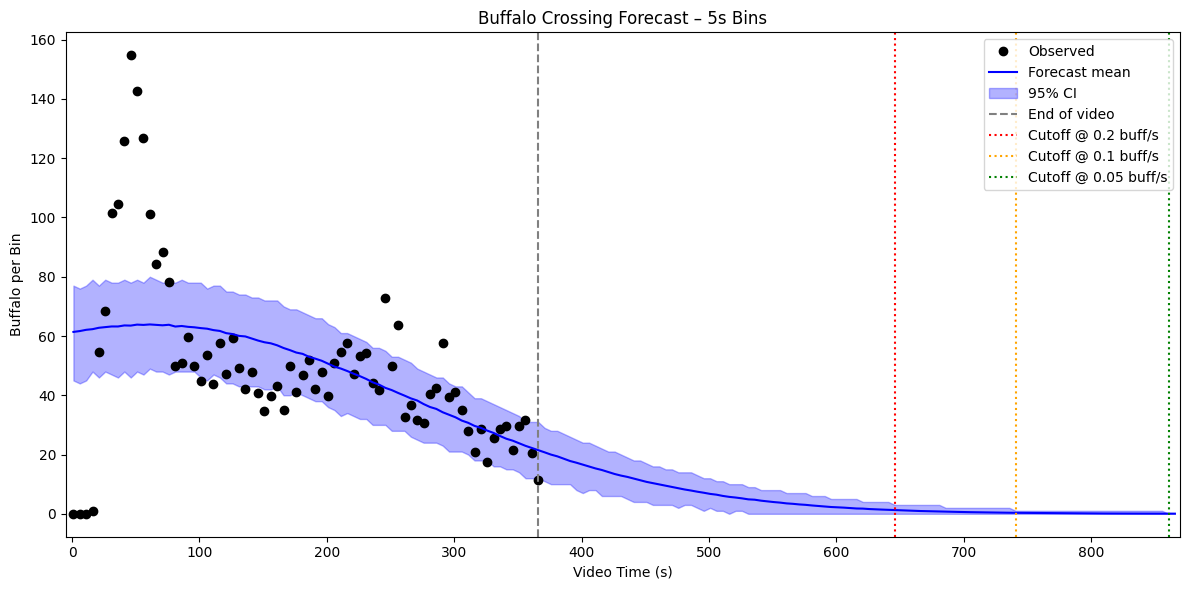

In [11]:
# Make plot showing only 5s bins (Figure included in main text)
plot_single_forecast_panel(counts_5s, traces[1], bin_width=5, speed_factor=3.5, thresholds=thresholds)

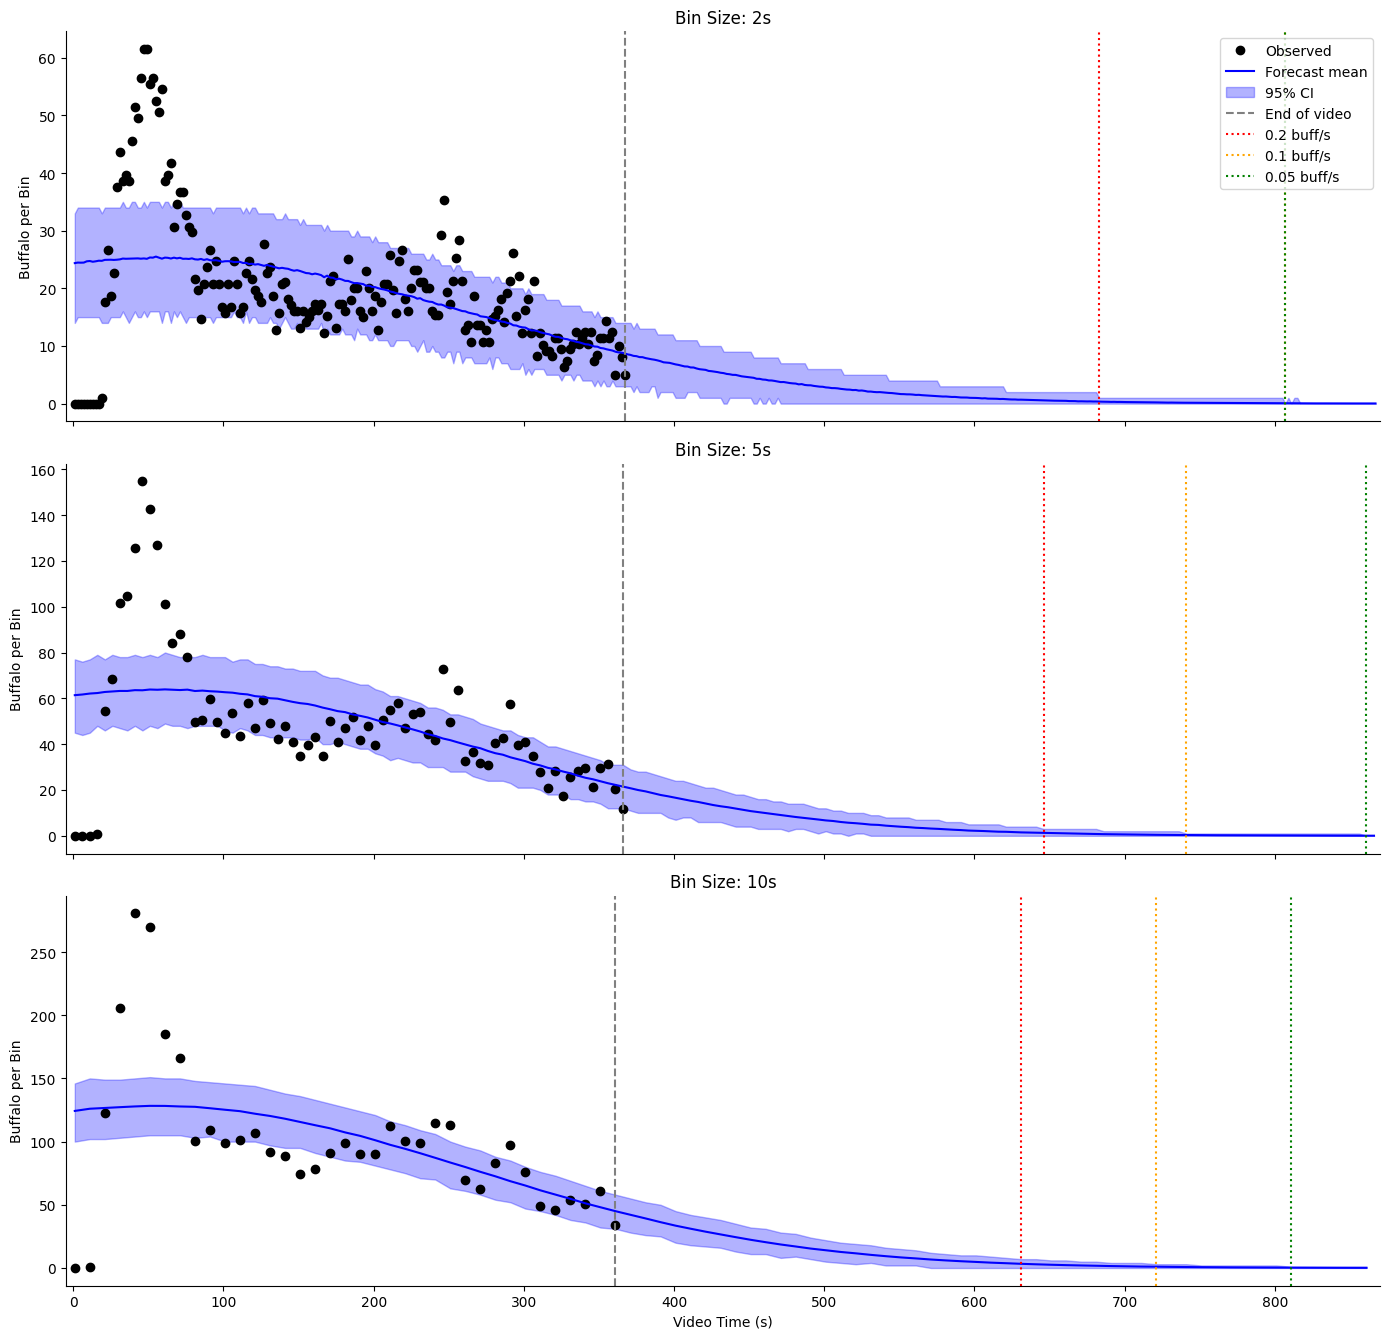

In [12]:
# Make plot showing all bin sizes with all thresholds (figure included in supplement)
plot_multi_bin_forecasts_shared_clean(
    count_lists=[counts_2s, counts_5s, counts_10s],
    pred_traces=traces,
    bin_sizes=[2, 5, 10],
    speed_factor=3.75,
    thresholds=thresholds
)